<img src="ost_logo.png" width="240" height="240" align="right"/>
<div style="text-align: left"> <b> Machine Learning </b> <br> MSE FTP MachLe <br> 
<a href="mailto:christoph.wuersch@ost.ch"> Christoph Würsch </a> </div>

# Lab 7, A3: Yelp Business Classification using Bag-of-Words and tf-idf

Yelp is a crowd-sourced review forum, as well as an American multinational corporation headquartered in San Francisco, California. It develops, hosts and markets Yelp.com and the Yelp mobile app, which publish crowd-sourced reviews about local businesses, as well as the online reservation service Yelp Reservations. The company also trains small businesses in
how to respond to reviews, hosts social events for reviewers, and provides data about businesses, including health inspection scores. The data is open and can be downloaded here https://www.yelp.com/dataset/challenge.

We have prepared a partial dataset from the big Yelp dataset in the __pickle serialization format__ that you can read into a pandas dataframe using ``pd.read_pickle``.


In [1]:
import json
import numpy as np
import pandas as pd
from sklearn.feature_extraction import text
from sklearn.linear_model import LogisticRegression
import sklearn.model_selection as modsel
import sklearn.preprocessing as preproc

### (a)  Load and prep Yelp reviews data

In [11]:
DataPath='D:/Downloads/YelpDataset/'
nightlife_subset = pd.read_pickle('nightlife_subset.pkl')
restaurant_subset = pd.read_pickle('restaurant_subset.pkl')
nightlife_subset.target.unique()
restaurant_subset.target.unique()
restaurant_subset.dtypes

business_id    object
name           object
stars_y         int64
text           object
categories     object
target           bool
dtype: object

### (b) combine both datasets

In [14]:
combined = pd.concat([nightlife_subset, restaurant_subset])
combined.iloc[0].categories

'Food, Restaurants, American (New), Local Flavor, Breakfast & Brunch, Bars, Breweries, Nightlife, Pubs'

In [15]:
combined['target'] = combined.apply(lambda x: 'Nightlife' in x['categories'],
                                    axis=1)

In [16]:
combined

,business_id,name,stars_y,text,categories,target
2203299,lpYFsXFrojiBZ1kbWR2lZw,Four Peaks Grill & Tap,5,Great service and food... Enjoy the atmosphere...,"Food, Restaurants, American (New), Local Flavo...",True
482774,KskYqH1Bi7Z_61pH6Om8pg,Lotus of Siam,5,Lotus is one of my all time favorites in Las V...,"Wine Bars, Nightlife, Restaurants, Seafood, Ca...",True
3086879,zFnPRtP7LGvr3sfxvy_dfg,Revolution Ale House,1,This place has definitely gone downhill. We fi...,"Nightlife, Italian, Restaurants, Pizza, Bars",True
512115,gUR2pWQKLPgMEm_R_aI_aw,Shooters On The Water,3,Thought this might be a worn out hang out for ...,"Dive Bars, American (New), American (Tradition...",True
3278073,hmYnzs8-aHbltaOOGDgmbA,Zipps Sports Grill,4,Zipps is almost always on happy hour! They hav...,"Sports Bars, American (Traditional), Nightlife...",True
...,...,...,...,...,...,...
2429937,Vs7gc9EE3k9wARuUcN9piA,Pan Asian,5,Pan Asian stays 5 stars for me. I went back t...,"Thai, Chinese, Japanese, Restaurants",False
640067,mYzlPKXvOVRrQivHnDqD5g,YamChops,5,Amazingly delicious with a variety of distinct...,"Butcher, Juice Bars & Smoothies, Vegan, Restau...",False
1566257,9Zl4uWSgSMpxHnsK_MPneg,Palermo Family Restaurant,4,"Eat here quite often, the Palermo Special piz...","Restaurants, Pizza",False
1607254,F-AYOq1xIY2u_qmWUG5VBw,Hakka Ren,5,It was amazing! I had the chilli fish schezuan...,"Chinese, Halal, Indian, Restaurants",False


### (c) Split the dataset into a training and test set

In [17]:
# Split into training and test data sets
training_data, test_data = modsel.train_test_split(combined, 
                                                   train_size=0.7, 
                                                   random_state=123)

In [18]:
training_data.shape

(14000, 6)

In [19]:
test_data.shape

(6000, 6)

### (d) Transform the text as BoW (bag-of-words)

In [20]:
# Represent the review text as a bag-of-words 
bow_transform = text.CountVectorizer()
X_tr_bow = bow_transform.fit_transform(training_data['text'])

In [21]:
len(bow_transform.vocabulary_)

29944

In [22]:
X_tr_bow.shape

(14000, 29944)

In [23]:
X_te_bow = bow_transform.transform(test_data['text'])

In [24]:
y_tr = training_data['target']
y_te = test_data['target']

### (e,f) Classify with logistic regression

In [27]:
def simple_logistic_classify(X_tr, y_tr, X_test, y_test, description, _C=1.0):
    ## Helper function to train a logistic classifier and score on test data
    m = LogisticRegression(C=_C, max_iter=5000).fit(X_tr, y_tr)
    s = m.score(X_test, y_test)
    print ('Test score with', description, 'features:', s)
    return m

In [28]:
m1 = simple_logistic_classify(X_tr_bow, y_tr, X_te_bow, y_te, 'bow')

Test score with bow features: 0.7146666666666667


### (f) applying normalization to the features

In [31]:
X_tr_l2 = preproc.normalize(X_tr_bow, axis=0)
X_te_l2 = preproc.normalize(X_te_bow, axis=0)

In [32]:
m2 = simple_logistic_classify(X_tr_l2, y_tr, X_te_l2, y_te, 'l2-normalized')

Test score with l2-normalized features: 0.7385


### (g) tf-idf represenation

In [34]:
# Create the tf-idf representation using the bag-of-words matrix
tfidf_trfm = text.TfidfTransformer(norm=None)
X_tr_tfidf = tfidf_trfm.fit_transform(X_tr_bow)

In [35]:
X_te_tfidf = tfidf_trfm.transform(X_te_bow)

In [36]:
m3 = simple_logistic_classify(X_tr_tfidf, y_tr, X_te_tfidf, y_te, 'tf-idf')

Test score with tf-idf features: 0.6828333333333333


### (h) Tune regularization parameters using grid search

In [39]:
param_grid_ = {'C': [1e-5, 1e-3, 1e-1, 1e0, 1e1, 1e2]}
bow_search = modsel.GridSearchCV(LogisticRegression(max_iter=5000), cv=5, param_grid=param_grid_, return_train_score=True)
l2_search  = modsel.GridSearchCV(LogisticRegression(max_iter=5000), cv=5, return_train_score=True,
                               param_grid=param_grid_)
tfidf_search = modsel.GridSearchCV(LogisticRegression(max_iter=5000), cv=5, return_train_score=True,
                                   param_grid=param_grid_)

In [40]:
bow_search.fit(X_tr_bow, y_tr)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=5000),
             param_grid={'C': [1e-05, 0.001, 0.1, 1.0, 10.0, 100.0]},
             return_train_score=True)

In [41]:
bow_search.best_score_

0.719

In [42]:
l2_search.fit(X_tr_l2, y_tr)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=5000),
             param_grid={'C': [1e-05, 0.001, 0.1, 1.0, 10.0, 100.0]},
             return_train_score=True)

In [43]:
l2_search.best_score_

0.7279285714285714

In [44]:
tfidf_search.fit(X_tr_tfidf, y_tr)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=5000),
             param_grid={'C': [1e-05, 0.001, 0.1, 1.0, 10.0, 100.0]},
             return_train_score=True)

In [45]:
tfidf_search.best_score_

0.7340714285714285

What regularization parameters are best for each method?

In [46]:
bow_search.best_params_

{'C': 0.1}

In [47]:
l2_search.best_params_

{'C': 1.0}

In [48]:
tfidf_search.best_params_

{'C': 0.001}

Let's check one of the grid search outputs to see how it went:

In [49]:
bow_search.cv_results_

{'mean_fit_time': array([0.13660936, 0.17765245, 1.04017844, 2.60140805, 3.66324058,
        4.66512613]),
 'std_fit_time': array([0.01378307, 0.00827466, 0.10594532, 0.5443235 , 0.1218784 ,
        0.89394898]),
 'mean_score_time': array([0.00194645, 0.00194349, 0.00186834, 0.0018868 , 0.00181561,
        0.00220184]),
 'std_score_time': array([0.00016726, 0.00022847, 0.00021265, 0.0002821 , 0.0002155 ,
        0.00034879]),
 'param_C': masked_array(data=[1e-05, 0.001, 0.1, 1.0, 10.0, 100.0],
              mask=[False, False, False, False, False, False],
        fill_value=1e+20),
 'params': [{'C': 1e-05},
  {'C': 0.001},
  {'C': 0.1},
  {'C': 1.0},
  {'C': 10.0},
  {'C': 100.0}],
 'split0_test_score': array([0.56535714, 0.70428571, 0.7125    , 0.69714286, 0.67892857,
        0.66821429]),
 'split1_test_score': array([0.55035714, 0.71178571, 0.72035714, 0.70785714, 0.68071429,
        0.67      ]),
 'split2_test_score': array([0.57285714, 0.70892857, 0.71642857, 0.70714286, 0.68285714

In [50]:
import pickle

In [52]:
results_file = open('tfidf_gridcv_results.pkl', 'wb')
pickle.dump(bow_search, results_file, -1)
pickle.dump(tfidf_search, results_file, -1)
pickle.dump(l2_search, results_file, -1)
results_file.close()

In [53]:
pkl_file = open('tfidf_gridcv_results.pkl', 'rb')
bow_search = pickle.load(pkl_file)
tfidf_search = pickle.load(pkl_file)
l2_search = pickle.load(pkl_file)
pkl_file.close()

In [54]:
search_results = pd.DataFrame.from_dict({'bow': bow_search.cv_results_['mean_test_score'],
                               'tfidf': tfidf_search.cv_results_['mean_test_score'],
                               'l2': l2_search.cv_results_['mean_test_score']})
search_results

,bow,tfidf,l2
0,0.560500,0.701786,0.502500
1,0.711929,0.734071,0.502500
2,0.719000,0.692500,0.710857
3,0.703286,0.673643,0.727929
4,0.679643,0.670643,0.714857
5,0.667500,0.678571,0.700357


## Plot cross validation results

In [55]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

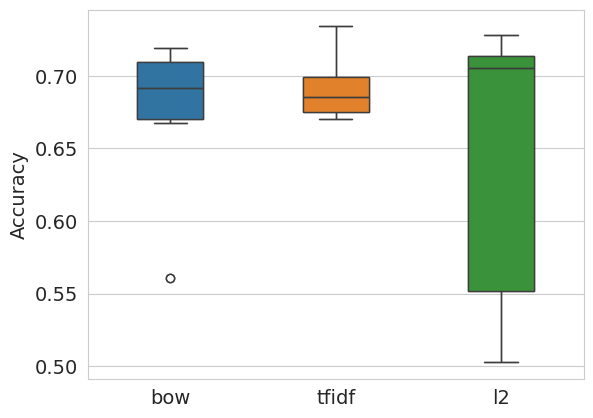

In [57]:
ax = sns.boxplot(data=search_results, width=0.4)
ax.set_ylabel('Accuracy', size=14)
ax.tick_params(labelsize=14)
plt.savefig('tfidf_gridcv_results.png')
plt.show()

In [58]:
m1 = simple_logistic_classify(X_tr_bow, y_tr, X_te_bow, y_te, 'bow', 
                              _C=bow_search.best_params_['C'])
m2 = simple_logistic_classify(X_tr_l2, y_tr, X_te_l2, y_te, 'l2-normalized', 
                              _C=l2_search.best_params_['C'])
m3 = simple_logistic_classify(X_tr_tfidf, y_tr, X_te_tfidf, y_te, 'tf-idf', 
                              _C=tfidf_search.best_params_['C'])

Test score with bow features: 0.7295
Test score with l2-normalized features: 0.7385
Test score with tf-idf features: 0.7413333333333333


In [59]:
bow_search.cv_results_['mean_test_score']

array([0.5605    , 0.71192857, 0.719     , 0.70328571, 0.67964286,
       0.6675    ])